Monte Carlo $\pi$ Estimation
============================
Monte Carlo methods are closely connected to the problem of numerical integration. Specifically, this particular method relies on the fact that the area of the unit circle is equal to $\pi$. If the circle is inscribed in the square of size 2 then the ratio between areas of two figures will be $4/\pi$. Now if we draw points $(x, y)$ randomly within the square and calculate the proportion of those in the square to those in the circle the proportion will be approximately $4/\pi$. Large sample size is more accurate the estimate.

Using this method we will generate random points in batches of size `batch_size` and compute the $\pi$ estimate for each batch as described above. The total number of batches is `n_batches`. With each new estimate we will progressively show how the overall estimate converges to the true value of $\pi$. We will also display an interval $(-stdev, +stdev)$, which is the measure of accuracy of the estimate

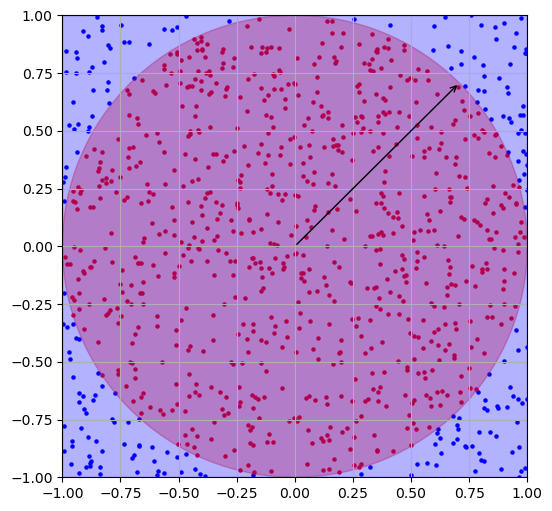

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np

N = 1000
x = np.random.uniform(-1, 1, N)
y = np.random.uniform(-1, 1, N)

c = plt.Circle((0, 0), 1, color='red', alpha=0.3)
r = plt.Rectangle((-1, -1), 2, 2, color='blue', alpha=0.3)
fig, ax = plt.subplots()
fig.set_size_inches(6, 6)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.grid(visible=True)
ax.annotate("", xy=(sqrt(2)/2, sqrt(2)/2), xytext=(0.0, 0.0), arrowprops=dict(arrowstyle="->"))
ax.add_patch(c)
ax.add_patch(r)

for i in range(N):
    plt.scatter(x[i], y[i], s=5, color='red' if x[i]*x[i]+y[i]*y[i]<=1 else 'blue')
    
plt.show()

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from time import time

Monte Carlo $\pi$ Estimation Using NumPy
----------------------------------------
The estimate is computed using NumPy vector operations on CPU. For implementation details please refer to the `monte_carlo_pi_batch()` function located in the file `/impl/impl_numpy.py`

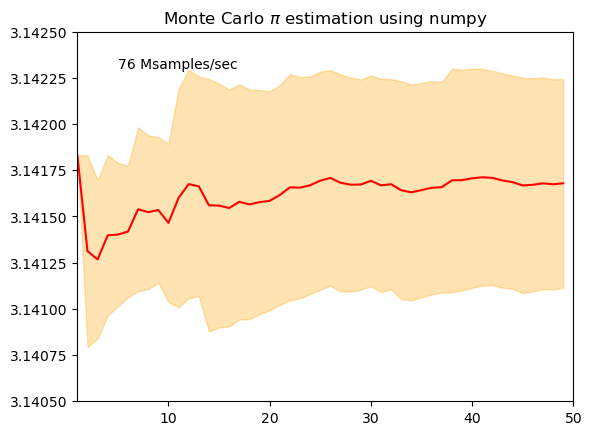

In [6]:
from mcpi_demo.impl.impl_numpy import monte_carlo_pi_batch
batch_size = 1024*10000
n_batches = 50
print(batch_size, n_batches)

x = []
y = []
zl = []
zh = []
est = np.empty(n_batches)
for i in range(n_batches):
    clear_output(wait=True)
    
    t1 = time()
    est[i] = monte_carlo_pi_batch(batch_size)
    t2 = time()
    
    avg = est[:i].mean()
    std = est[:i].std()
    
    x.append(i)
    y.append(avg)
    zl.append(avg-std)
    zh.append(avg+std)
    
    plt.xlim([1, n_batches])
    plt.ylim([3.1405, 3.1425])
   
    plt.plot(x, y, '-r', color='red')
    plt.fill_between(x, zl, zh, color='orange', alpha=0.3)
    plt.text(5, 3.1423, f"{batch_size/(t2-t1)/1e6:.0f} Msamples/sec")
    plt.title(r"Monte Carlo $\pi$ estimation using numpy")
    plt.show()

Monte Carlo $\pi$ Estimation Using Data Parallel Extension for NumPy
--------------------------------------------------------------------
Having the above NumPy example it is straightforward to run the same implementation on GPU by substituting `import numpy as np` with `import dpnp as np`. The `dpnp.random.random` will generate random points on the default device, which is GPU:

In [5]:
import dpnp as np
x = np.random.random(10)
print(x.device)

Device(level_zero:gpu:0)


For details please refer to the implementation of `monte_carlo_pi_batch()` located in the file `/impl/impl_dpnp.py`

In [ ]:
from mcpi_demo.impl.impl_dpnp import monte_carlo_pi_batch
import numpy as np
batch_size = 1024*10000
n_batches = 50
print(batch_size, n_batches)

x = []
y = []
zl = []
zh = []
est = np.empty(n_batches)
for i in range(n_batches):
    clear_output(wait=True)
    
    t1 = time()
    est[i] = monte_carlo_pi_batch(batch_size)
    t2 = time()
    
    avg = est[:i].mean()
    std = est[:i].std()
    
    x.append(i)
    y.append(avg)
    zl.append(avg-std)
    zh.append(avg+std)
    
    plt.xlim([1, n_batches])
    plt.ylim([3.1405, 3.1425])
   
    plt.plot(x, y, '-r', color='red')
    plt.fill_between(x, zl, zh, color='orange', alpha=0.3)
    plt.text(5, 3.1423, f"{batch_size/(t2-t1)/1e6:.0f} Msamples/sec")
    plt.title(r"Monte Carlo $\pi$ estimation using dpnp")
    plt.show()

Monte Carlo $\pi$ Estimation Using Numba
----------------------------------------
Numba is the Just-In-Time (JIT) compiler for Python functions. Using the `@njit(parallel=True)` function decorator you can trigger the compilation of that function into native code with automatic parallelization, which would allow using all CPU cores. For implementation details please refer to For details please refer to the file `/impl/impl_numba.py`

In [ ]:
from mcpi_demo.impl.impl_numba import monte_carlo_pi_batch
batch_size = 1024*10000
n_batches = 50
print(batch_size, n_batches)

x = []
y = []
zl = []
zh = []
est = np.empty(n_batches)
for i in range(n_batches):
    clear_output(wait=True)
    
    t1 = time()
    est[i] = monte_carlo_pi_batch(batch_size)
    t2 = time()
    
    avg = est[:i].mean()
    std = est[:i].std()
    
    x.append(i)
    y.append(avg)
    zl.append(avg-std)
    zh.append(avg+std)
    
    plt.xlim([1, n_batches])
    plt.ylim([3.1405, 3.1425])
   
    plt.plot(x, y, '-r', color='red')
    plt.fill_between(x, zl, zh, color='orange', alpha=0.3)
    plt.text(5, 3.1423, f"{batch_size/(t2-t1)/1e6:.0f} Msamples/sec")
    plt.title(r"Monte Carlo $\pi$ estimation using numba")
    plt.show()

Can Numba compile the code for GPU? The answer is yes, if you use Data Parallel Extension for Numba, or `numba-dpex`. Using its `@dpjit` decorator you can trigger code compilation to a specific device. The device is selected based on where data is allocated. Since we generate random points using `dpnp.random.random` by default it allocates these points on GPU, hence respective `@dpjit` code will trigger compilation for GPU too.

For details please refer to the implementation of `monte_carlo_pi_batch()` located in the file `/impl/impl_numba_dpex.py`

In [1]:
from mcpi_demo.impl.impl_numba_dpex import monte_carlo_pi_batch
batch_size = 1024*10000
n_batches = 50
print(batch_size, n_batches)

x = []
y = []
zl = []
zh = []
est = np.empty(n_batches)
for i in range(n_batches):
    clear_output(wait=True)
    
    t1 = time()
    est[i] = monte_carlo_pi_batch(batch_size)
    t2 = time()
    
    avg = est[:i].mean()
    std = est[:i].std()
    
    x.append(i)
    y.append(avg)
    zl.append(avg-std)
    zh.append(avg+std)
    
    plt.xlim([1, n_batches])
    plt.ylim([3.1405, 3.1425])
   
    plt.plot(x, y, '-r', color='red')
    plt.fill_between(x, zl, zh, color='orange', alpha=0.3)
    plt.text(5, 3.1423, f"{batch_size/(t2-t1)/1e6:.0f} Msamples/sec")
    plt.title(r"Monte Carlo $\pi$ estimation using numba")
    plt.show()

C:\Users\smaidano\AppData\Local\miniconda3\envs\dp-mpl\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


10240000 50


NameError: name 'np' is not defined